<a href="https://colab.research.google.com/github/ABCDeath/study/blob/main/y_training_2.0/assignment07_mnist_classification/assignment_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [1]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1:
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Text(0.5, 1.0, 'Image label: 8')

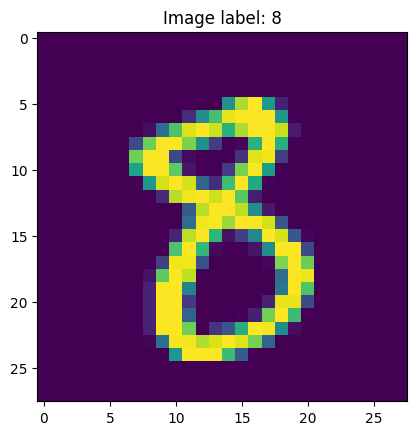

In [2]:
# do not change the code in the block below
# __________start of block__________

# Load MNIST data using TensorFlow
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Create TensorFlow datasets
train_data_loader = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_data_loader = train_data_loader.shuffle(60000).batch(32)

test_data_loader = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_data_loader = test_data_loader.batch(32)

# Get a random batch for visualization
random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.numpy().reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [ ]:
shape = _image.shape[0] * _image.shape[1]
# Creating model instance

Локальные тесты для проверки вашей модели доступны ниже:

In [ ]:
# do not change the code in the block below
# __________start of block__________
# assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = tf.reshape(random_batch[0], (-1, 784))
    y = random_batch[1]

    # compute outputs given inputs, both are variables
#    y_predicted = model(x)
except Exception as e:
    print('Something is wrong with the model')
    raise e


# assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

#### Layers implementation

In [100]:
class DenseLayer(tf.Module):
    def __init__(self, shape, activation = None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.activation = activation
        self.w = tf.Variable(tf.random.normal(shape[::-1])*0.01, name='weights')
        self.b = tf.Variable(tf.zeros((shape[-1],)), name='biases')

    def __call__(self, x):
        linear_out = tf.matmul(x, tf.transpose(self.w)) + self.b
        return self.activation(linear_out) if self.activation else linear_out

class Model(tf.Module):
    def __init__(self, *layers, **kwargs):
        super().__init__(**kwargs)

        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

In [ ]:
def loss_fn(target, prediction):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(target, prediction))

@tf.function
def train_epoch(model, data_loader, loss_fn, lr=1e-2):
    loss = 0.
    for batch in data_loader:
        images, labels = batch
        with tf.GradientTape() as tape:
            x = tf.reshape(images, (-1, 784))
            logits = model(x)
            loss = loss_fn(tf.cast(labels, tf.int32), logits)

        trainables = tuple((layer.w,  layer.b) for layer in model.layers)
        gradients = tape.gradient(loss, trainables)
        for i, layer in enumerate(model.layers):
            dw, db = gradients[i]

            layer.w.assign_sub(lr * dw)
            layer.b.assign_sub(lr * db)

    return loss

models = (
    Model(
        DenseLayer(shape=(shape, 128), activation=tf.nn.relu),
        DenseLayer(shape=(128, 64), activation=tf.nn.relu),
        DenseLayer(shape=(64, 10)),
    ),
    Model(
        DenseLayer(shape=(shape, 128), activation=tf.nn.relu),
        DenseLayer(shape=(128, 32), activation=tf.nn.relu),
        DenseLayer(shape=(32, 10)),
    ),
    Model(
        DenseLayer(shape=(shape, 64), activation=tf.nn.relu),
        DenseLayer(shape=(64, 64), activation=tf.nn.relu),
        DenseLayer(shape=(64, 10)),
    ),
    Model(
        DenseLayer(shape=(shape, 64), activation=tf.nn.relu),
        DenseLayer(shape=(64, 16), activation=tf.nn.relu),
        DenseLayer(shape=(16, 10)),
    ),
)

best_model, model_loss = models[0], 1e10
for i, model in enumerate(models):
    print(f'=================== `Model {i}` ===================')

    loss = 0.
    for epoch in range(15):
        loss = train_epoch(model, train_data_loader, loss_fn, lr=5e-3)

        print(f'epoch: {epoch}, loss: {loss:.4f}')

    if loss < model_loss:
        best_model, model_loss = model, loss

my_model = best_model

=================== `Model 0` ===================
epoch: 0, loss: 2.2948
epoch: 1, loss: 2.2856
epoch: 2, loss: 2.2619
epoch: 3, loss: 1.6011
epoch: 4, loss: 0.6450
epoch: 5, loss: 0.3734
epoch: 6, loss: 0.5705
epoch: 7, loss: 0.4703
epoch: 8, loss: 0.2512
epoch: 9, loss: 0.3284
epoch: 10, loss: 0.3709
epoch: 11, loss: 0.2329
epoch: 12, loss: 0.3263
epoch: 13, loss: 0.3170
epoch: 14, loss: 0.1576
=================== `Model 1` ===================
epoch: 0, loss: 2.3042
epoch: 1, loss: 2.2932
epoch: 2, loss: 2.2953
epoch: 3, loss: 2.2665
epoch: 4, loss: 1.6119
epoch: 5, loss: 0.8303
epoch: 6, loss: 0.4386
epoch: 7, loss: 0.4740
epoch: 8, loss: 0.3696
epoch: 9, loss: 0.1882
epoch: 10, loss: 0.2901
epoch: 11, loss: 0.2430
epoch: 12, loss: 0.2459
epoch: 13, loss: 0.3499
epoch: 14, loss: 0.4291
=================== `Model 2` ===================
epoch: 0, loss: 2.3018
epoch: 1, loss: 2.3043
epoch: 2, loss: 2.2957
epoch: 3, loss: 2.1427
epoch: 4, loss: 1.6710
epoch: 5, loss: 0.7908
epoch: 6, lo

#### Using keras entities

In [118]:
def build_model(layer1_units, layer2_units):
    input_layer = tf.keras.layers.Input(shape=(shape,))
    layer1 = tf.keras.layers.Dense(layer1_units, activation=tf.keras.activations.relu)(input_layer)
    layer2 = tf.keras.layers.Dense(layer2_units, activation=tf.keras.activations.relu)(layer1)
    output = tf.keras.layers.Dense(10)(layer2)

    return tf.keras.Model(inputs=input_layer, outputs=output)

@tf.function
def train_epoch(model, data_loader, optimizer, loss_fn):
    loss = 0.
    for batch in data_loader:
        images, labels = batch
        with tf.GradientTape() as tape:
            x = tf.reshape(images, (-1, 784))
            logits = model(x, training=True)
            loss = loss_fn(tf.cast(labels, tf.int32), logits)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

lr = 5e-4
models = (
    (build_model(128, 64), tf.keras.optimizers.SGD(learning_rate=lr)),
    (build_model(128, 32), tf.keras.optimizers.SGD(learning_rate=lr)),
    (build_model(64, 64), tf.keras.optimizers.SGD(learning_rate=lr)),
    (build_model(64, 16), tf.keras.optimizers.SGD(learning_rate=lr)),

    (build_model(128, 64), tf.keras.optimizers.Adam(learning_rate=lr)),
    (build_model(128, 32), tf.keras.optimizers.Adam(learning_rate=lr)),
    (build_model(64, 64), tf.keras.optimizers.Adam(learning_rate=lr)),
    (build_model(64, 16), tf.keras.optimizers.Adam(learning_rate=lr)),
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

best_model, model_loss = models[0], 1e10
for i, (model, optimizer) in enumerate(models):
    print(f'=================== `Model {i}` ===================')

    loss = 0.
    for epoch in range(15):
        loss = train_epoch(model, train_data_loader, optimizer, loss_fn)

        print(f'epoch: {epoch}, loss: {loss:.4f}')

    if loss < model_loss:
        best_model, model_loss = model, loss

keras_entities_model = best_model

=================== `Model 0` ===================
epoch: 0, loss: 1.8813
epoch: 1, loss: 1.3490
epoch: 2, loss: 0.9570
epoch: 3, loss: 0.6859
epoch: 4, loss: 0.5017
epoch: 5, loss: 0.6206
epoch: 6, loss: 0.6556
epoch: 7, loss: 0.4482
epoch: 8, loss: 0.4511
epoch: 9, loss: 0.3968
epoch: 10, loss: 0.5096
epoch: 11, loss: 0.3010
epoch: 12, loss: 0.5576
epoch: 13, loss: 0.3890
epoch: 14, loss: 0.1332
=================== `Model 1` ===================
epoch: 0, loss: 1.9605
epoch: 1, loss: 1.3166
epoch: 2, loss: 1.0409
epoch: 3, loss: 0.6691
epoch: 4, loss: 0.6701
epoch: 5, loss: 0.7772
epoch: 6, loss: 0.5697
epoch: 7, loss: 0.6321
epoch: 8, loss: 0.5995
epoch: 9, loss: 0.3896
epoch: 10, loss: 0.3373
epoch: 11, loss: 0.4824
epoch: 12, loss: 0.3755
epoch: 13, loss: 0.5656
epoch: 14, loss: 0.5290
=================== `Model 2` ===================
epoch: 0, loss: 2.0265
epoch: 1, loss: 1.6540
epoch: 2, loss: 1.2779
epoch: 3, loss: 1.0557
epoch: 4, loss: 0.7611
epoch: 5, loss: 0.5123
epoch: 6, lo

#### Keras model

In [123]:
def build_model(layer1_units, layer2_units, optimizer, loss_fn):
    model = tf.keras.models.Sequential(
        (
            tf.keras.layers.Input(shape=(28, 28)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(layer1_units, activation=tf.keras.activations.relu),
            tf.keras.layers.Dense(layer2_units, activation=tf.keras.activations.relu),
            tf.keras.layers.Dense(10),
        )
    )

    model.compile(optimizer=optimizer, loss=loss_fn)

    return model

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

lr = 1e-3
models = (
    build_model(128, 64, tf.keras.optimizers.SGD(learning_rate=lr), loss_fn),
    build_model(128, 32, tf.keras.optimizers.SGD(learning_rate=lr), loss_fn),
    build_model(64, 64, tf.keras.optimizers.SGD(learning_rate=lr), loss_fn),
    build_model(64, 16, tf.keras.optimizers.SGD(learning_rate=lr), loss_fn),

    build_model(128, 64, tf.keras.optimizers.Adam(learning_rate=lr), loss_fn),
    build_model(128, 32, tf.keras.optimizers.Adam(learning_rate=lr), loss_fn),
    build_model(64, 64, tf.keras.optimizers.Adam(learning_rate=lr), loss_fn),
    build_model(64, 16, tf.keras.optimizers.Adam(learning_rate=lr), loss_fn),
)

best_model, model_loss = models[0], 1e10
for i, model in enumerate(models):
    print(f'=================== `Model {i}` ===================')

    history = model.fit(train_data_loader, epochs=15)

    loss = history.history['loss'][-1]
    if loss < model_loss:
        best_model, model_loss = model, loss

keras_model = best_model

=================== `Model 0` ===================
Epoch 1/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 2.2041
Epoch 2/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.6785
Epoch 3/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.1883
Epoch 4/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8869
Epoch 5/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7231
Epoch 6/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6207
Epoch 7/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5568
Epoch 8/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5151
Epoch 9/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4763
Epoch 10/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4506
Epoch 11/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4285
Epoch 12/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.4141
Epoch 13/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3999
Epoch 14/15
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [125]:
def test_train(model, reshape=True):
    predicted_labels = []
    real_labels = []

    for batch in train_data_loader:
        images, labels = batch
        x = images.numpy().reshape(-1, 784) if reshape else images
        y_predicted = model(x)
        predicted_labels.append(tf.argmax(y_predicted, axis=1))
        real_labels.append(labels)

    predicted_labels = tf.concat(predicted_labels, axis=0)
    real_labels = tf.concat(real_labels, axis=0)
    train_acc = tf.reduce_mean(tf.cast(predicted_labels == tf.cast(real_labels, tf.int64), tf.float32))

    print(f'Neural network accuracy on train set: {train_acc:3.5}')

In [126]:
def test_test(model, reshape=True):
    predicted_labels = []
    real_labels = []

    for batch in test_data_loader:
        images, labels = batch
        x = images.numpy().reshape(-1, 784) if reshape else images
        y_predicted = model(x)
        predicted_labels.append(tf.argmax(y_predicted, axis=1))
        real_labels.append(labels)

    predicted_labels = tf.concat(predicted_labels, axis=0)
    real_labels = tf.concat(real_labels, axis=0)
    test_acc = tf.reduce_mean(tf.cast(predicted_labels == tf.cast(real_labels, tf.int64), tf.float32))

    print(f'Neural network accuracy on test set: {test_acc:3.5}')

In [127]:
test_train(my_model)
test_test(my_model)

test_train(keras_entities_model)
test_test(keras_entities_model)

test_train(keras_model, reshape=False)
test_test(keras_model, reshape=False)

Neural network accuracy on train set: 0.92498
Neural network accuracy on test set: 0.9237
Neural network accuracy on train set: 0.99747
Neural network accuracy on test set: 0.9776
Neural network accuracy on train set: 0.9987
Neural network accuracy on test set: 0.9794


Проверка, что необходимые пороги пройдены:

In [106]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

AssertionError: Test accuracy is below 0.92 threshold

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [128]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy

--2026-01-22 16:10:15--  https://raw.githubusercontent.com/girafe-ai/ml-course/23s_dd_ml/homeworks/hw07_mnist_classification/hw07_data_dict.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272438 (6.0M) [application/octet-stream]
Saving to: ‘hw07_data_dict.npy’

hw07_data_dict.npy  100%[===================>]   5.98M  --.-KB/s    in 0.02s   

2026-01-22 16:10:15 (397 MB/s) - ‘hw07_data_dict.npy’ saved [6272438/6272438]



In [136]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    predicted_labels = []

    for idx in range(0, len(eval_data), step):
        batch = eval_data[idx:idx+step].reshape(-1, 784)
        y_predicted = model(batch)
        predicted_labels.append(tf.argmax(y_predicted, axis=1))

    predicted_labels = tf.concat(predicted_labels, axis=0)
    return predicted_labels.numpy()

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(keras_entities_model, loaded_data_dict.item()['train'].astype('float32')),
    'test': get_predictions(keras_entities_model, loaded_data_dict.item()['test'].astype('float32'))
}

np.save('submission_dict_hw07.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw07.npy`')
# __________end of block__________

File saved to `submission_dict_hw07.npy`


На этом задание завершено. Поздравляем!

In [139]:
import json
import codecs

submission_dict_json = {
    'train': ','.join(str(s) for s in get_predictions(keras_entities_model, loaded_data_dict.item()['train'].astype('float32'))),
    'test': ','.join(str(s) for s in get_predictions(keras_entities_model, loaded_data_dict.item()['test'].astype('float32'))),
}

json.dump(
    submission_dict_json, codecs.open('submission_dict_hw07.npy', 'w', encoding='utf-8'),
    separators=(',', ':'),
    sort_keys=True,
    indent=4
) ### this saves the array in • json format
